In [1]:
import os
import sys
import random
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# needed to import sinex and sinexc as module
sys.path.append('./code/')

In [3]:
src = 'dataset/logmel'

In [4]:
test_cat = ['27', '46', '04', '56', '55']

### Utils (Get Batch)

In [5]:
def open_pickle_file(filepath):    
    file = open(filepath, 'rb')
    return pickle.load(file)

In [6]:
def get_n_random_classes_without_parameter_value(speakers_list, n, val):
    listcopy = speakers_list.copy()
    listcopy.remove(val)
    return random.sample(listcopy, n)

In [7]:
def get_one_shot_batch(_classes, xclass, N):
    X, S, labels = [], [], []

    # Selecting a random spectrogram for the current class (query spect x)
    xspects = glob.glob(os.path.join(src, xclass, "*pickle"))
    xs_idx = random.randint(0, len(xspects) - 1)
    xpath = xspects[xs_idx]
    x = open_pickle_file(xpath)
    xspects.remove(xpath)

    # Selecting another random spectrogram from query x class 
    xx_idx = random.randint(0, len(xspects) - 1)
    xxpath = xspects[xx_idx]
    xx = open_pickle_file(xxpath)

    # Appending x and xx from the same class
    X.append([x, xx])
    S.append(xx)
    labels.append([xclass, xclass])

    # Appending different categories's spectrograms, 1 per xclass per each of the xclass of test set
    dcs = get_n_random_classes_without_parameter_value(_classes, N - 1, xclass)
    dcs.sort()
    
    for dc in dcs:
        dspects = glob.glob(os.path.join(src, dc, "*pickle"))
        ds_idx = random.randint(0, len(dspects) - 1)
        ds = open_pickle_file(dspects[ds_idx])

        # Appending query spect x and spectrogram from a different class
        X.append([x, ds])
        S.append(ds)
        labels.append([xclass, dc])
    
    return (x, np.array(S), np.array(X), np.array(labels))

##### Import of Siamese Network tensorflow model

In [8]:
import tensorflow as tf
from keras import backend as K

model = tf.keras.models.load_model("model/model")
model.load_weights('model/model_weights.h5')
model.summary()

2022-05-31 13:22:12.066363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 13:22:12.066443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38595628    ['input_2[0][0]',                
                                                                

### VISUALIZATION

In [9]:
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams.update({'font.size': 17})

In [10]:
# Restituisco soltanto il max de valore assoluto
## Nella visualizzazione poi al vmin passo -np.max dei massimi
### Uso i valori assoluti perchè è la stessa cosa di fare il percentile 100esimo del val assoluto
#### ed è la stessa descritta in diversi paper che ho letto (parlano solo di abs value)
def get_attribution_max(data):
    return np.max(np.abs(data))

def get_all_maxes(attributions):
    abs_maxs = []
    
    for attribution in attributions:
        abs_maxs.append(get_attribution_max(attribution))
        
    return abs_maxs

In [11]:
def plot_explanation(x, S, labels, attributions, abs_maxes, probabilities):
    N = len(attributions)
    
    plt.figure()
    f, axarr = plt.subplots(2, N + 1,figsize=(30,10))

    axarr[0, 0].imshow(x, origin="lower")
    axarr[0, 0].set_axis_off()
    axarr[0, 0].set_title('Query x; y = ' + str(labels[0][0]))

    for i in range(N):
        # Prima riga attributions
        sim = round(probabilities[i][0], 3)

        axarr[0, i+1].imshow(attributions[i], cmap=cmap_to_use, origin="lower", interpolation='none', vmin=-np.max(abs_maxes), vmax=np.max(abs_maxes))
        axarr[0, i+1].set_axis_off()
        subscripth = 'h' + str(i+1)
        axarr[0, i+1].set_title(subscripth + '; y = ' + str(labels[i][1]))
        
        # Seconda riga right input originali
        axarr[1, i+1].imshow(S[i], origin="lower")
        axarr[1, i+1].set_axis_off()
        
        subscripts = 's' + str(i+1)
        axarr[1, i+1].set_title(subscripts + "; sim = " + str(sim))

    # Empty 2 row 1 column element
    axarr[1, 0].set_axis_off()
    axarr[1, 0].text(0.0, 0.5, '') 

    plt.show()

In [12]:
shap_cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#1E88E5-91C5F2-FFFFFF-FF6395-FF0052
    (0.000, (0.118, 0.533, 0.898)),
    (0.250, (0.569, 0.773, 0.949)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.750, (1.000, 0.388, 0.584)),
    (1.000, (1.000, 0.000, 0.322))))

# cmap_to_use = "RdBu_r"
cmap_to_use = shap_cmap

### Example

In [13]:
x, S, pairs, labels = get_one_shot_batch(test_cat, '04', len(test_cat))
probabilities = model.predict([pairs[:, 0], pairs[:, 1]]) # storing probabilities

for p in probabilities:
    print(p[0])

0.89594275
0.083241925
0.0022223059
0.041649476
1.6758091e-05


2022-05-31 13:22:24.067103: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 13:22:24.111180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## SINEX

In [14]:
from sinex import Sinex

In [15]:
# SINEX initialization parameters
algo = 'felzenszwalb'

# Felzenszwalb parameters
params = {
    'scale':50,     # Free parameter. Higher means larger clusters.
    'sigma':1.5,    # Width (standard deviation) of Gaussian kernel used in preprocessing.
    'min_size':150  # Minimum component size. Enforced using postprocessing.
}

# spectrograms shape
shape = (224, 224, 1)

In [16]:
# Initialize SINEX 
sinex = Sinex(algo, params, shape)

In [17]:
# Get SINEX explanations
E = sinex.explain(model, x, S)

2022-05-31 13:22:29.851040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Analyzig support set index: 0 Predicted similarity: 0.89594275
Analyzig support set index: 1 Predicted similarity: 0.083241925
Analyzig support set index: 2 Predicted similarity: 0.0022223059
Analyzig support set index: 3 Predicted similarity: 0.041649476
Analyzig support set index: 4 Predicted similarity: 1.6758091e-05


<Figure size 432x288 with 0 Axes>

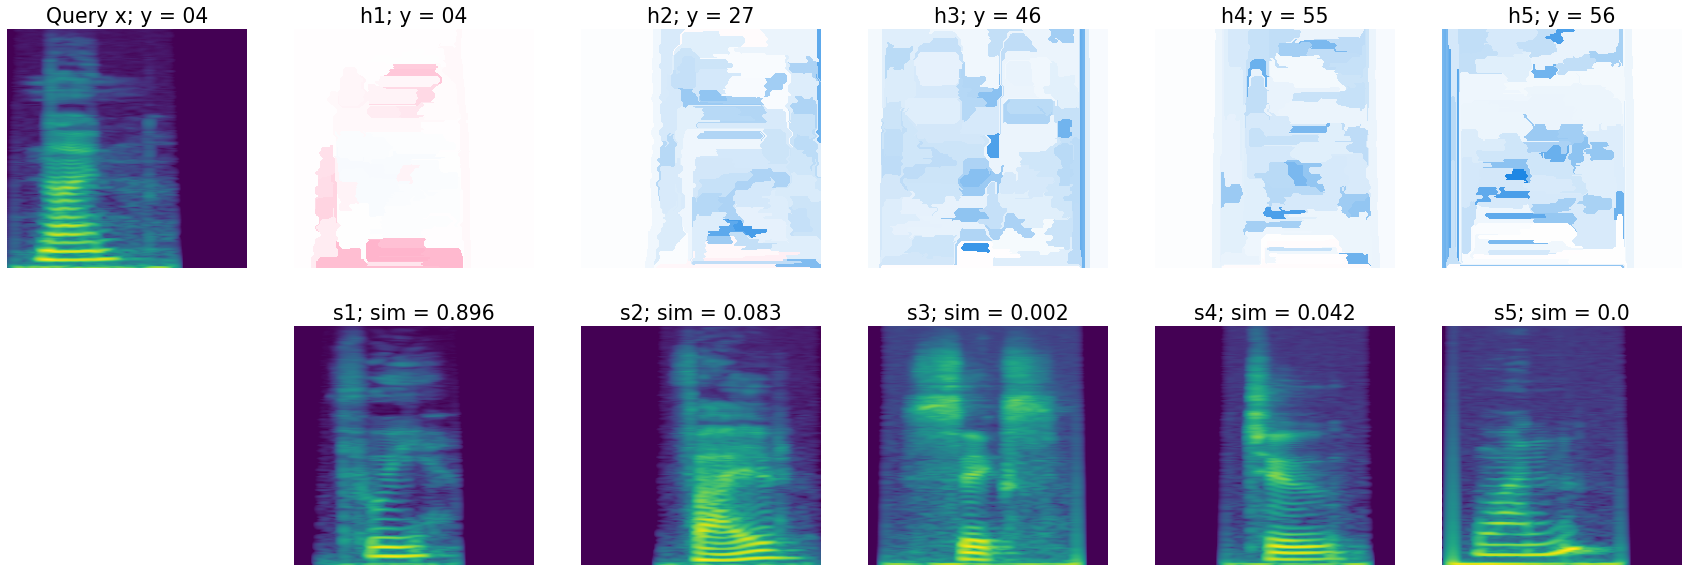

In [18]:
# Plot SINEX explanations
plot_explanation(x, S, labels, E, get_all_maxes(E), probabilities)

## SINEXC

In [19]:
from sinexc import Sinexc

In [20]:
# SINEXC initialization parameters
algo = 'felzenszwalb'

# Felzenszwalb parameters
params = {
    'scale':50,     # Free parameter. Higher means larger clusters.
    'sigma':1.5,    # Width (standard deviation) of Gaussian kernel used in preprocessing.
    'min_size':900  # Minimum component size. Enforced using postprocessing.
}

# spectrograms shape
shape = (224, 224, 1)

alpha = 150 # per-segment coalitions
beta = 0.15 # per-coalition active segments in % value

In [21]:
# Initialize SINEXC
sinexc = Sinexc(algo, params, shape, alpha, beta)

In [22]:
# Get SINEXC explanations
E = sinexc.explain(model, x, S)

Analyzig support set index: 0 Predicted similarity: 0.89594275
Analyzig support set index: 1 Predicted similarity: 0.083241925
Analyzig support set index: 2 Predicted similarity: 0.0022223059
Analyzig support set index: 3 Predicted similarity: 0.041649476
Analyzig support set index: 4 Predicted similarity: 1.6758091e-05


<Figure size 432x288 with 0 Axes>

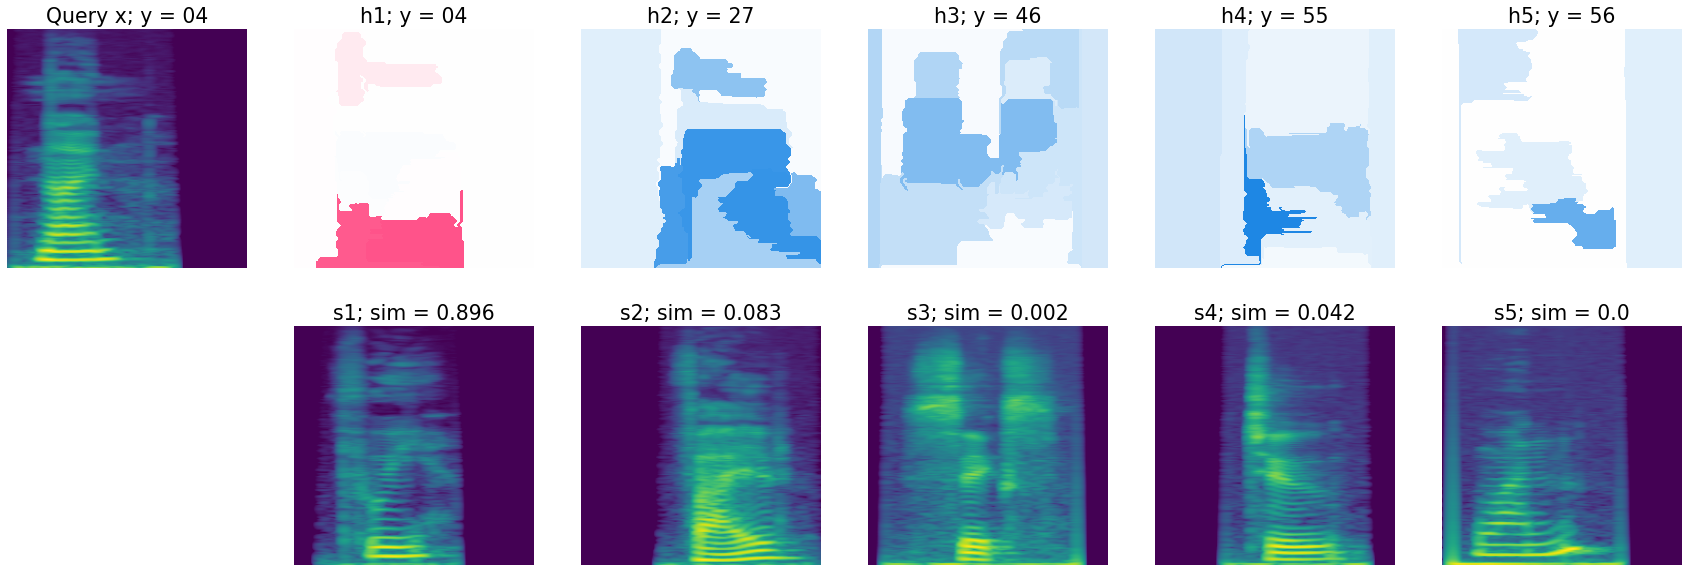

In [23]:
# Plot SINEXC explanations
plot_explanation(x, S, labels, E, get_all_maxes(E), probabilities)